<a href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/OU_process/Models/boundary_pinn_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import torch
import torch.nn as nn
from torch.nn import ReLU
from torch.utils.data import Dataset, DataLoader
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.integrate as integrate
import scipy.special as special
import scipy.ndimage as ndimage

# Solving for the MET of an Ornstein-Uhlenbeck process in a disk with "Boundary Fitted PINNs" : comparison with exact solution

## 1) Setup

For $\theta,\sigma,r >0$ some fixed parameters, we let $\Omega := B_r \equiv \{x\in\mathbb R^d : \|x\|< r \}$, and define the process ($d=2$ in our illustration) :

$$\begin{cases} dX_t &= -\theta X_t dt + \sigma dB_t \\
X_0 &= x \in \Omega \end{cases} $$

For all $x\in\Omega$, let

$$T(x) := \inf\{t\ge 0 : X_t \in\partial\Omega\} $$

and let its first moment be denoted

$$\tau(x) := \mathbb E[T(x)] $$

We can show under some regularity conditions on $\Omega$ that $\tau$ is the (unique) solution of the BVP :

$$\begin{cases} \mathcal{L}u(x) &= -1 \text{ for all } x\in\Omega \\
u(x) &= 0 \text{ for all } x\in\partial\Omega \end{cases} $$

where $\mathcal L$ is the infinitesimal generator of the Ornstein-Uhlenbeck process, given by
$$\mathcal Lu : x \mapsto -\theta x \cdot \nabla u(x) + \frac{\sigma^2}{2}\Delta u(x) $$

Nicely enough, for this problem, we can compare our solution with the known closed-form solution (see https://arxiv.org/abs/2208.04029) :

$$ \tau(x) := \frac{1}{\lambda^{d/2}\sigma^2}\int_\rho^r z^{1-d} e^{\lambda z^2} \gamma(d/2, \lambda z^2)\ dz $$

where $\lambda := \theta/\sigma^2 $, $\rho := \|x\| $ and $\gamma$ is the upper incomplete gamma function :
$$\gamma(n,y) := \int_0^y t^{n-1} e^{-t}\ dt.  $$

In [41]:
#radius of the ball
radius = 2

#parameters of the OU process
theta = 1
sigma = 0.5
lambda_ = theta/sigma**2

#definition of the true solution for comparison

def true_solution(x, y, theta=theta, lambda_=lambda_):
    rho = np.sqrt(x**2 + y**2)
    integral, _ = integrate.quad(lambda t : np.exp(lambda_ * t**2) * special.gammainc(1, lambda_ * t**2) / t, rho, radius)
    return integral/theta

#make the true_solution compatible with numpy arrays
true_solution_vectorized = np.vectorize(true_solution)

#plotting the function
n_points = 400
tt = np.linspace(-1, 1, n_points) * radius
xx, yy = np.meshgrid(tt, tt)  # create unit square grid

xx, yy = np.where(xx**2 + yy**2 <= radius**2, xx, 0), np.where(xx**2 + yy**2 <= radius**2 , yy, 0)
zz = true_solution_vectorized(xx,yy)

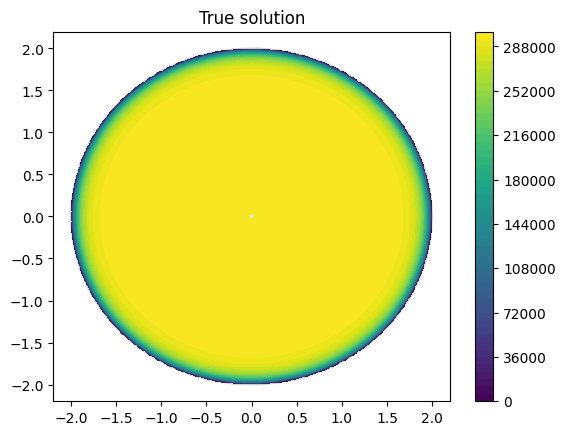

In [42]:
#circle
a = np.linspace(0, 2*np.pi, 50)
cx,cy = np.cos(a) * radius , np.sin(a)*radius

fig, ax = plt.subplots()
ax.plot(cx, cy,'k-', alpha=.2)

contour = ax.contourf(xx, yy, zz, levels=50)  # 50 contour levels
ax.set_title("True solution")
cb = fig.colorbar(contour, ax=ax)

As we can see, the true solution blows up extremely fast away from the boundary, and is thus likely to be hard to learn.

## 2) Setting up the Neural Network architecture and loss function

Unlike the standard PINN, we will take an hypothesis space of Neural Networks which satisfy the boundary conditions explicitly. For this problem, we have homogenous zero Dirichlet boundary conditions, which we can enforce by multiplying our Neural Networks with an appropriate "smooth distance approximation" (see https://arxiv.org/abs/2104.08426). In accordance with the mentioned paper, we will take
$$\varphi : x\mapsto \frac{r^2 - \|x\|^2}{2r}$$
as our smooth distance approximation.  


With this modification, our objective to minimize becomes
$$\hat u := \arg\min_{u\in\mathcal{NN}}\ \frac1n \sum_{i=1}^n (\mathcal L u(x_i^c) + 1)^2 $$
where $x_i^c$ are sampled i.i.d. with uniform distribution on $\Omega$,
$$\mathcal{NN}:=\left\{x\mapsto \sum_{i=1}^m \beta_i\ \sigma_k(\theta_i\cdot x + \omega_i)\mid (\beta_i,\omega_i, \theta_i)\in\mathbb R^{2+d}\right\} $$
and
$$\sigma_k :x \mapsto \begin{cases}x^k &\text{ if } x\ge 0\\ 0 &\text{ if } x\le 0\end{cases} $$
is the ReLU$^k$ activation.

In [43]:
#define our NN architecture
power = 2
width = 150
magnitude = 3 #magnitude of weights at initialization

#define ReLU^k activation

class RePU(nn.Module):
    def __init__(self, power = power):
        super(RePU, self).__init__()
        self.power = power

    def forward(self, x):
        return torch.pow(torch.relu(x), self.power)


#define the smooth distance approximation

def smooth_distance(x):
    norm_x = torch.linalg.norm(x, dim=-1)
    return (radius**2 - norm_x**2)/(2*radius)

#define hypothesis space
class BoundaryPINN(nn.Module):
    def __init__(self, power = 2, width = width):
        super().__init__()

        self.layers = torch.nn.Sequential(torch.nn.Linear(2, width),
                                          RePU(power),
                                          torch.nn.Linear(width, 1))

    def forward(self, x):
        output = self.layers(x)
        distance =  smooth_distance(x)
        return torch.pow(output,2) * distance.unsqueeze(-1)

In [56]:
#all functions needed for training

def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    """
    This function calculates the derivative of the model at x
    """
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs = torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy

def u_function(model: BoundaryPINN, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    This function evaluates the model on the input x
    """
    model_input = torch.stack((x, y), axis = 1)
    return model(model_input)


def residual(model, x_c, y_c):
    u = u_function(model, x_c, y_c)
    u_x = derivative(u, x_c, order=1)
    u_y = derivative(u, y_c, order=1)
    u_xx = derivative(u, x_c, order=2)
    u_yy = derivative(u, y_c, order=2)
    res = - theta * (x_c * u_x + y_c * u_y) \
        + sigma**2 * (u_xx + u_yy)/2 \
        + 1
    return res

def loss_function(model: BoundaryPINN, x_c: torch.Tensor, y_c: torch.Tensor) -> torch.Tensor:
    """
    This function evaluates the physics governing the model on the input x
    """
    domain_residual = residual(model, x_c, y_c).pow(2).mean() #residual
    return domain_residual

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight, gain=magnitude)
        m.bias.data.fill_(magnitude)

## 3) Preparation of the training data  

sampling $n = N_c$ collocation points in $\Omega$.

In [57]:
N_c = 1200 #number of points in the domain

#definition of X_c_train : N_c points in the disk
t = np.random.uniform(0,2*np.pi, N_c)
rho = np.sqrt(np.random.uniform(0,radius**2, N_c)) #uniform distribution on the disk
x_c = rho * np.cos(t)
y_c = rho * np.sin(t)
X_c_train = np.vstack( (x_c, y_c) )

#shuffling X_c_train
index = np.arange(0, N_c)
np.random.shuffle(index)
X_c_train = X_c_train[:,index]

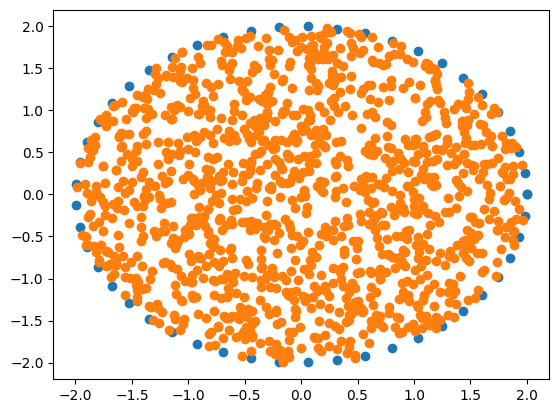

In [58]:
#checking the collocation points
plt.scatter(cx,cy)
plt.scatter(x_c,y_c)

## 4) Training the model and visualizing the results

In [59]:
class TrainingData(Dataset):
    def __init__(self, X_c):
        self.X_c = X_c

    def __len__(self):
        return self.X_c.shape[1]

    def __getitem__(self, index):
        X_c = self.X_c[:, index]
        return X_c

In [60]:
def train_one_epoch(model, optimizer):
    running_loss = 0.
    last_loss = 0.
    n_display = (N_c//batch_size)//3

    for i, X_c in enumerate(dataloader):

        x_c = X_c[0,:]
        y_c = X_c[1,:]

        optimizer.zero_grad()

        # Compute the loss and its gradients
        loss = loss_function(model, x_c, y_c)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if (i+1) % n_display == 0 :
            last_loss = running_loss / n_display # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            losses.append(last_loss)
            running_loss = 0.

    return last_loss

In [61]:
#training parameters
batch_size = 12
learning_rate_adam = 5e-5
learning_rate_sgd = 5e-4
dampening = learning_rate_sgd/10
method = 'Adam' #'SGD' or 'Adam', Adam strongly recommended
losses = []

#model instantiation
model = BoundaryPINN()
model.apply(init_weights)

# Loading the data for training
X_c_train_tensor = torch.from_numpy(X_c_train).requires_grad_(True).float()

dataset = TrainingData(X_c_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size)

if method == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_adam)

elif method == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_sgd, dampening=dampening)

elif method not in ['Adam', 'SGD']:
    raise ValueError('You need to specify Adam or SGD as a training method')

In [62]:
#training loop
n_epochs = 500
epoch_number = 0

for epoch in range(n_epochs):
    epoch_number += 1
    print('EPOCH {}:'.format(epoch_number))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(model, optimizer)
    print('LOSS train {}'.format(avg_loss))

EPOCH 1:
  batch 33 loss: 34048694.72348485
  batch 66 loss: 11411831.392045455
  batch 99 loss: 46920046.48106061
LOSS train 46920046.48106061
EPOCH 2:
  batch 33 loss: 27829775.4375
  batch 66 loss: 9171654.304924242
  batch 99 loss: 39613318.22561553
LOSS train 39613318.22561553
EPOCH 3:
  batch 33 loss: 23174353.299242426
  batch 66 loss: 7473111.168560606
  batch 99 loss: 33681627.74526515
LOSS train 33681627.74526515
EPOCH 4:
  batch 33 loss: 19453326.928030305
  batch 66 loss: 6139204.570075758
  batch 99 loss: 28824023.807291668
LOSS train 28824023.807291668
EPOCH 5:
  batch 33 loss: 16442658.24810606
  batch 66 loss: 5079901.820075758
  batch 99 loss: 24813409.93128551
LOSS train 24813409.93128551
EPOCH 6:
  batch 33 loss: 13984084.928030303
  batch 66 loss: 4230972.017992424
  batch 99 loss: 21476429.0715554
LOSS train 21476429.0715554
EPOCH 7:
  batch 33 loss: 11960044.661458334
  batch 66 loss: 3545057.4356060605
  batch 99 loss: 18680025.091145832
LOSS train 18680025.09114

In [63]:
#if needed, we add a subsequent training loop


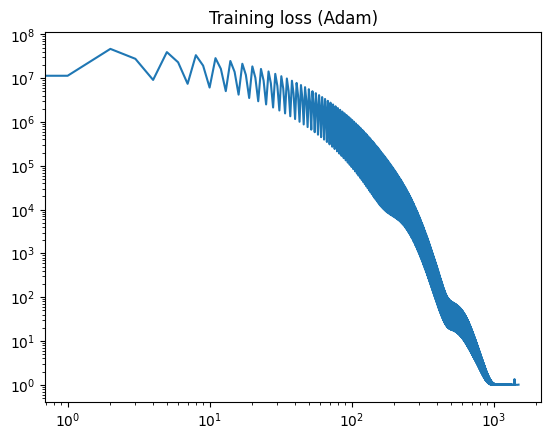

In [64]:
plt.loglog(losses)
plt.title(f'Training loss ({method})')
plt.show()

In [65]:
# save the model
torch.save(model.state_dict(), f'boundary_pinn_{method}.pt')

<ipython-input-66-e81e143fb3c1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f'boundary_pinn_{method}.pt'))


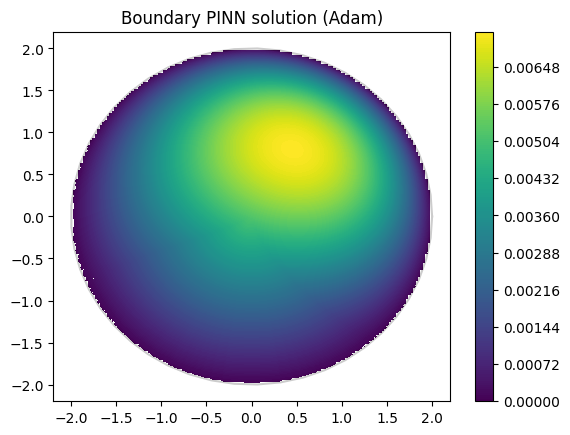

In [66]:
#load the model
model = BoundaryPINN()
model.load_state_dict(\
torch.load(f'boundary_pinn_{method}.pt'))

#evaluate the model on a uniform grid
n_points = 150
tt = np.linspace(-1, 1, n_points) * radius
xx, yy = np.meshgrid(tt, tt)  # create unit square grid
xx, yy = np.where(xx**2 + yy**2 <= radius**2, xx, 0), np.where(xx**2 + yy**2 <= radius**2 , yy, 0) #(https://stackoverflow.com/questions/15733530/)
#zz_true = true_solution_vectorized(xx,yy)

input = torch.from_numpy(np.vstack((xx.ravel(),yy.ravel())).T).float()#.requires_grad_(False)
learned_sol = model(input)

#plot
learned_sol_np = learned_sol.detach().numpy().reshape(xx.shape)
#learned_sol_smooth = ndimage.gaussian_filter(learned_sol_np, sigma=0.1, order=0) #smoothing for visualization

fig, ax = plt.subplots()
ax.plot(cx, cy,'k-', alpha=.2)
contour = ax.contourf(xx, yy, learned_sol_np, levels=200)
ax.set_title(f'Boundary PINN solution ({method})')
cb = fig.colorbar(contour, ax=ax)

In [67]:
#verify that the model is zero on the boundary
circle = torch.from_numpy(np.vstack((cx.ravel(),cy.ravel())).T).float()#.requires_grad_(False)
torch.sum(model(circle)**2) #== 0

tensor(1.0181e-17, grad_fn=<SumBackward0>)